# Notebook 08: Similarity & Recommendation System

**Objective**: Build a Digimon recommendation system based on multiple similarity metrics.

This notebook implements:
- Multiple similarity metrics (attributes, moves, graph distance, embeddings)
- Content-based filtering recommendations
- Evolution path recommendations
- Team composition recommendations

---

## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, jaccard
import warnings
warnings.filterwarnings('ignore')

# Custom utilities
from utils import (
    Neo4jConnector,
    calculate_centrality_measures,
    save_figure,
    TYPE_COLORS, ATTRIBUTE_COLORS, LEVEL_COLORS
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


# Notebook configuration
notebook_name = "08_recommendation_system"
print("Environment setup complete!")

Environment setup complete!


## 2. Load Data and Build Feature Matrix

In [ ]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Load all data
digimon_df = conn.get_all_digimon()
evolution_data = conn.get_evolution_chains()
moves_df = conn.get_digimon_moves()

# Remove any rows with missing name_en
digimon_df = digimon_df.dropna(subset=['name_en'])

print(f"\nLoaded data:")
print(f"  - {len(digimon_df)} Digimon (with valid names)")
print(f"  - {len(evolution_data)} evolution relationships")
print(f"  - {len(moves_df)} move relationships")

In [4]:
# Build comprehensive feature matrix
print("\n=== BUILDING FEATURE MATRIX ===")

# Start with basic attributes
features_df = digimon_df[['name_en', 'level', 'type', 'attribute']].copy()
features_df.set_index('name_en', inplace=True)

# 1. One-hot encode categorical features
# Type encoding (keep top 30 types)
top_types = digimon_df['type'].value_counts().head(30).index
for t in top_types:
    features_df[f'type_{t}'] = (features_df['type'] == t).astype(int)

# Attribute encoding
for attr in ['Vaccine', 'Virus', 'Data', 'Free']:
    features_df[f'attr_{attr}'] = (features_df['attribute'] == attr).astype(int)

# Level encoding
level_order = {'Baby': 0, 'In-Training': 1, 'Rookie': 2, 'Champion': 3, 
               'Ultimate': 4, 'Mega': 5, 'Ultra': 6}
features_df['level_numeric'] = features_df['level'].map(level_order).fillna(3)

# 2. Move-based features
print("Adding move-based features...")
# Create move matrix for each Digimon
move_matrix = moves_df.pivot_table(
    index='digimon', 
    columns='move', 
    values='move',
    aggfunc='count',
    fill_value=0
)
# Keep only moves that appear in at least 5 Digimon
common_moves = move_matrix.columns[move_matrix.sum() >= 5]
move_matrix = move_matrix[common_moves]

# Add move features
features_df = features_df.join(move_matrix, how='left').fillna(0)

# 3. Graph-based features
print("Adding graph-based features...")
# Build graph
G = nx.Graph()
for _, digimon in digimon_df.iterrows():
    if digimon['name_en'] is not None:  # Safety check
        G.add_node(digimon['name_en'])

# Add evolution edges
for evo in evolution_data:
    if evo['from_digimon'] in G and evo['to_digimon'] in G:
        G.add_edge(evo['from_digimon'], evo['to_digimon'])

# Calculate centrality measures
centrality_df = calculate_centrality_measures(G)
features_df = features_df.join(centrality_df[['degree', 'betweenness', 'eigenvector']], 
                               how='left').fillna(0)

# 4. Evolution statistics
evolution_df = pd.DataFrame(evolution_data)
in_degree = evolution_df.groupby('to_digimon').size()
out_degree = evolution_df.groupby('from_digimon').size()
features_df['evolution_in'] = features_df.index.map(in_degree).fillna(0)
features_df['evolution_out'] = features_df.index.map(out_degree).fillna(0)

print(f"\nFinal feature matrix shape: {features_df.shape}")
print(f"Features include: categorical encodings, {len(common_moves)} moves, graph metrics")


=== BUILDING FEATURE MATRIX ===
Adding move-based features...
Adding graph-based features...

Final feature matrix shape: (1258, 43)
Features include: categorical encodings, 0 moves, graph metrics


## 3. Calculate Similarity Matrices

In [5]:
# Prepare numeric features only
numeric_features = features_df.select_dtypes(include=[np.number]).columns
feature_matrix = features_df[numeric_features].fillna(0)

# Normalize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)
feature_matrix_scaled = pd.DataFrame(
    feature_matrix_scaled, 
    index=feature_matrix.index, 
    columns=feature_matrix.columns
)

In [6]:
# 1. Cosine Similarity (overall features)
print("=== CALCULATING SIMILARITY MATRICES ===")
print("\n1. Cosine similarity...")
cosine_sim = cosine_similarity(feature_matrix_scaled)
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=feature_matrix.index,
    columns=feature_matrix.index
)

# 2. Move-based Jaccard Similarity
print("2. Move-based Jaccard similarity...")
move_features = [col for col in feature_matrix.columns if col in common_moves]
move_matrix_binary = (feature_matrix[move_features] > 0).astype(int)

# Calculate Jaccard similarity
jaccard_sim = np.zeros((len(move_matrix_binary), len(move_matrix_binary)))
for i in range(len(move_matrix_binary)):
    for j in range(i, len(move_matrix_binary)):
        if i == j:
            jaccard_sim[i, j] = 1.0
        else:
            vec1 = move_matrix_binary.iloc[i].values
            vec2 = move_matrix_binary.iloc[j].values
            if vec1.sum() == 0 and vec2.sum() == 0:
                similarity = 0
            else:
                similarity = 1 - jaccard(vec1, vec2)
            jaccard_sim[i, j] = similarity
            jaccard_sim[j, i] = similarity

jaccard_sim_df = pd.DataFrame(
    jaccard_sim,
    index=feature_matrix.index,
    columns=feature_matrix.index
)

# 3. Type-Attribute Similarity
print("3. Type-Attribute similarity...")
type_attr_features = [col for col in feature_matrix.columns 
                     if col.startswith('type_') or col.startswith('attr_')]
type_attr_sim = cosine_similarity(feature_matrix[type_attr_features])
type_attr_sim_df = pd.DataFrame(
    type_attr_sim,
    index=feature_matrix.index,
    columns=feature_matrix.index
)

# 4. Graph Distance Similarity
print("4. Graph distance similarity...")
# Calculate shortest path distances (sample for efficiency)
sample_size = min(500, len(G.nodes()))
sample_nodes = list(G.nodes())[:sample_size]

graph_distances = {}
for node in sample_nodes:
    if node in G:
        distances = nx.single_source_shortest_path_length(G, node, cutoff=5)
        graph_distances[node] = distances

# Convert to similarity (inverse of distance)
graph_sim = np.zeros((len(sample_nodes), len(sample_nodes)))
for i, node1 in enumerate(sample_nodes):
    for j, node2 in enumerate(sample_nodes):
        if node1 in graph_distances and node2 in graph_distances[node1]:
            distance = graph_distances[node1][node2]
            graph_sim[i, j] = 1 / (1 + distance)
        elif i == j:
            graph_sim[i, j] = 1.0
        else:
            graph_sim[i, j] = 0.0

graph_sim_df = pd.DataFrame(
    graph_sim,
    index=sample_nodes,
    columns=sample_nodes
)

print("\nSimilarity matrices calculated successfully!")

=== CALCULATING SIMILARITY MATRICES ===

1. Cosine similarity...
2. Move-based Jaccard similarity...
3. Type-Attribute similarity...
4. Graph distance similarity...

Similarity matrices calculated successfully!


## 4. Recommendation Functions

In [7]:
def recommend_similar_digimon(digimon_name, similarity_matrix, top_k=10, exclude_self=True):
    """
    Find most similar Digimon based on given similarity matrix.
    """
    if digimon_name not in similarity_matrix.index:
        return f"Digimon '{digimon_name}' not found in database."
    
    # Get similarity scores
    similarities = similarity_matrix.loc[digimon_name].sort_values(ascending=False)
    
    # Exclude self if requested
    if exclude_self:
        similarities = similarities[similarities.index != digimon_name]
    
    # Get top K
    recommendations = similarities.head(top_k)
    
    # Add metadata
    result = []
    for rec_name, score in recommendations.items():
        if rec_name in digimon_df.set_index('name_en').index:
            digimon_info = digimon_df.set_index('name_en').loc[rec_name]
            result.append({
                'name': rec_name,
                'similarity': score,
                'type': digimon_info['type'],
                'attribute': digimon_info['attribute'],
                'level': digimon_info['level']
            })
    
    return pd.DataFrame(result)


def recommend_evolution_path(digimon_name, evolution_graph, digimon_data):
    """
    Recommend optimal evolution paths for a Digimon.
    """
    if digimon_name not in evolution_graph:
        return f"Digimon '{digimon_name}' not found in evolution graph."
    
    # Get current Digimon info
    current_info = digimon_data[digimon_data['name_en'] == digimon_name].iloc[0]
    current_level = current_info['level']
    
    # Find all possible evolutions
    descendants = nx.descendants(evolution_graph, digimon_name)
    
    # Find paths to each descendant
    evolution_paths = []
    for descendant in descendants:
        try:
            paths = list(nx.all_simple_paths(evolution_graph, digimon_name, descendant, cutoff=5))
            for path in paths:
                # Calculate path score based on final Digimon's attributes
                final_digimon = digimon_data[digimon_data['name_en'] == path[-1]].iloc[0]
                
                # Score based on level progression and popularity (degree)
                level_score = level_order.get(final_digimon['level'], 0)
                popularity_score = evolution_graph.degree(path[-1])
                
                evolution_paths.append({
                    'path': ' → '.join(path),
                    'length': len(path) - 1,
                    'final_digimon': path[-1],
                    'final_level': final_digimon['level'],
                    'final_type': final_digimon['type'],
                    'score': level_score + popularity_score * 0.1
                })
        except:
            continue
    
    # Sort by score and return top paths
    evolution_df = pd.DataFrame(evolution_paths)
    if len(evolution_df) > 0:
        return evolution_df.sort_values('score', ascending=False).head(10)
    else:
        return "No evolution paths found for this Digimon."


def recommend_team_composition(current_team, all_digimon, similarity_matrix, 
                             diversity_weight=0.7, synergy_weight=0.3):
    """
    Recommend Digimon to add to a team for balanced composition.
    """
    if not current_team:
        return "Please provide at least one Digimon in the current team."
    
    # Get current team attributes
    team_data = all_digimon[all_digimon['name_en'].isin(current_team)]
    team_types = team_data['type'].value_counts()
    team_attributes = team_data['attribute'].value_counts()
    team_levels = team_data['level'].value_counts()
    
    # Find candidates (exclude current team)
    candidates = all_digimon[~all_digimon['name_en'].isin(current_team)]
    
    recommendations = []
    for _, candidate in candidates.iterrows():
        candidate_name = candidate['name_en']
        
        # Diversity score (prefer different types/attributes)
        type_diversity = 1.0 if candidate['type'] not in team_types else 0.2
        attr_diversity = 1.0 if candidate['attribute'] not in team_attributes else 0.5
        diversity_score = (type_diversity + attr_diversity) / 2
        
        # Synergy score (average similarity to team members)
        if candidate_name in similarity_matrix.index:
            synergies = []
            for team_member in current_team:
                if team_member in similarity_matrix.columns:
                    synergies.append(similarity_matrix.loc[candidate_name, team_member])
            synergy_score = np.mean(synergies) if synergies else 0
        else:
            synergy_score = 0
        
        # Combined score
        total_score = diversity_weight * diversity_score + synergy_weight * synergy_score
        
        recommendations.append({
            'name': candidate_name,
            'type': candidate['type'],
            'attribute': candidate['attribute'],
            'level': candidate['level'],
            'diversity_score': diversity_score,
            'synergy_score': synergy_score,
            'total_score': total_score
        })
    
    # Sort and return top recommendations
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df.sort_values('total_score', ascending=False).head(10)

## 5. Demonstration of Recommendation System

In [8]:
# Example 1: Find similar Digimon
test_digimon = "Agumon"
print(f"=== RECOMMENDATIONS FOR {test_digimon} ===")

# Overall similarity
print("\n1. Overall Similarity (all features):")
overall_recs = recommend_similar_digimon(test_digimon, cosine_sim_df, top_k=10)
if isinstance(overall_recs, pd.DataFrame):
    print(overall_recs)
else:
    print(overall_recs)

=== RECOMMENDATIONS FOR Agumon ===

1. Overall Similarity (all features):
Digimon 'Agumon' not found in database.


In [9]:
# Move-based similarity
print("\n2. Move-based Similarity:")
move_recs = recommend_similar_digimon(test_digimon, jaccard_sim_df, top_k=10)
if isinstance(move_recs, pd.DataFrame):
    print(move_recs)


2. Move-based Similarity:


In [10]:
# Type-Attribute similarity
print("\n3. Type-Attribute Similarity:")
type_attr_recs = recommend_similar_digimon(test_digimon, type_attr_sim_df, top_k=10)
if isinstance(type_attr_recs, pd.DataFrame):
    print(type_attr_recs)


3. Type-Attribute Similarity:


In [11]:
# Example 2: Evolution path recommendations
print(f"\n=== EVOLUTION PATHS FOR {test_digimon} ===")

# Build directed evolution graph
evolution_graph = nx.DiGraph()
for _, digimon in digimon_df.iterrows():
    if digimon['name_en'] is not None:  # Safety check
        evolution_graph.add_node(digimon['name_en'])
        
for evo in evolution_data:
    if evo['from_digimon'] in evolution_graph and evo['to_digimon'] in evolution_graph:
        evolution_graph.add_edge(evo['from_digimon'], evo['to_digimon'])

evolution_paths = recommend_evolution_path(test_digimon, evolution_graph, digimon_df)
if isinstance(evolution_paths, pd.DataFrame):
    print(evolution_paths)
else:
    print(evolution_paths)


=== EVOLUTION PATHS FOR Agumon ===
Digimon 'Agumon' not found in evolution graph.


In [12]:
# Example 3: Team composition recommendations
current_team = ["Agumon", "Gabumon", "Patamon"]
print(f"\n=== TEAM COMPOSITION RECOMMENDATIONS ===")
print(f"Current team: {', '.join(current_team)}")

team_recs = recommend_team_composition(current_team, digimon_df, cosine_sim_df)
if isinstance(team_recs, pd.DataFrame):
    print("\nRecommended additions:")
    print(team_recs[['name', 'type', 'attribute', 'level', 'total_score']].head(10))


=== TEAM COMPOSITION RECOMMENDATIONS ===
Current team: Agumon, Gabumon, Patamon

Recommended additions:
                   name                   type attribute     level  \
0             ABBADOMON  Tribe unknown Species   Unknown      Mega   
835         PARASAURMON          dinosaur Type     Virus  Champion   
842             PECKMON              bird Type   Vaccine  Champion   
841          PEACOCKMON           Machine Type      Free     Armor   
840  PAUNCHESSMON-WHITE            Puppet Type     Virus    Rookie   
839        PAUNCHESSMON            Puppet Type     Virus    Rookie   
838             PATAMON         mammalian Type      Data    Rookie   
837           PARROTMON        Giant bird Type   Vaccine  Ultimate   
836           PARASIMON         Parasitic Type     Virus      Mega   
834              PAOMON             Slime Type              Baby I   

     total_score  
0            0.7  
835          0.7  
842          0.7  
841          0.7  
840          0.7  
839       

## 6. Similarity Analysis Visualizations

Saved: ../results/figures/similarity_distributions.png
Saved: ../results/figures/similarity_distributions.svg
Saved: ../results/figures/similarity_distributions.pdf


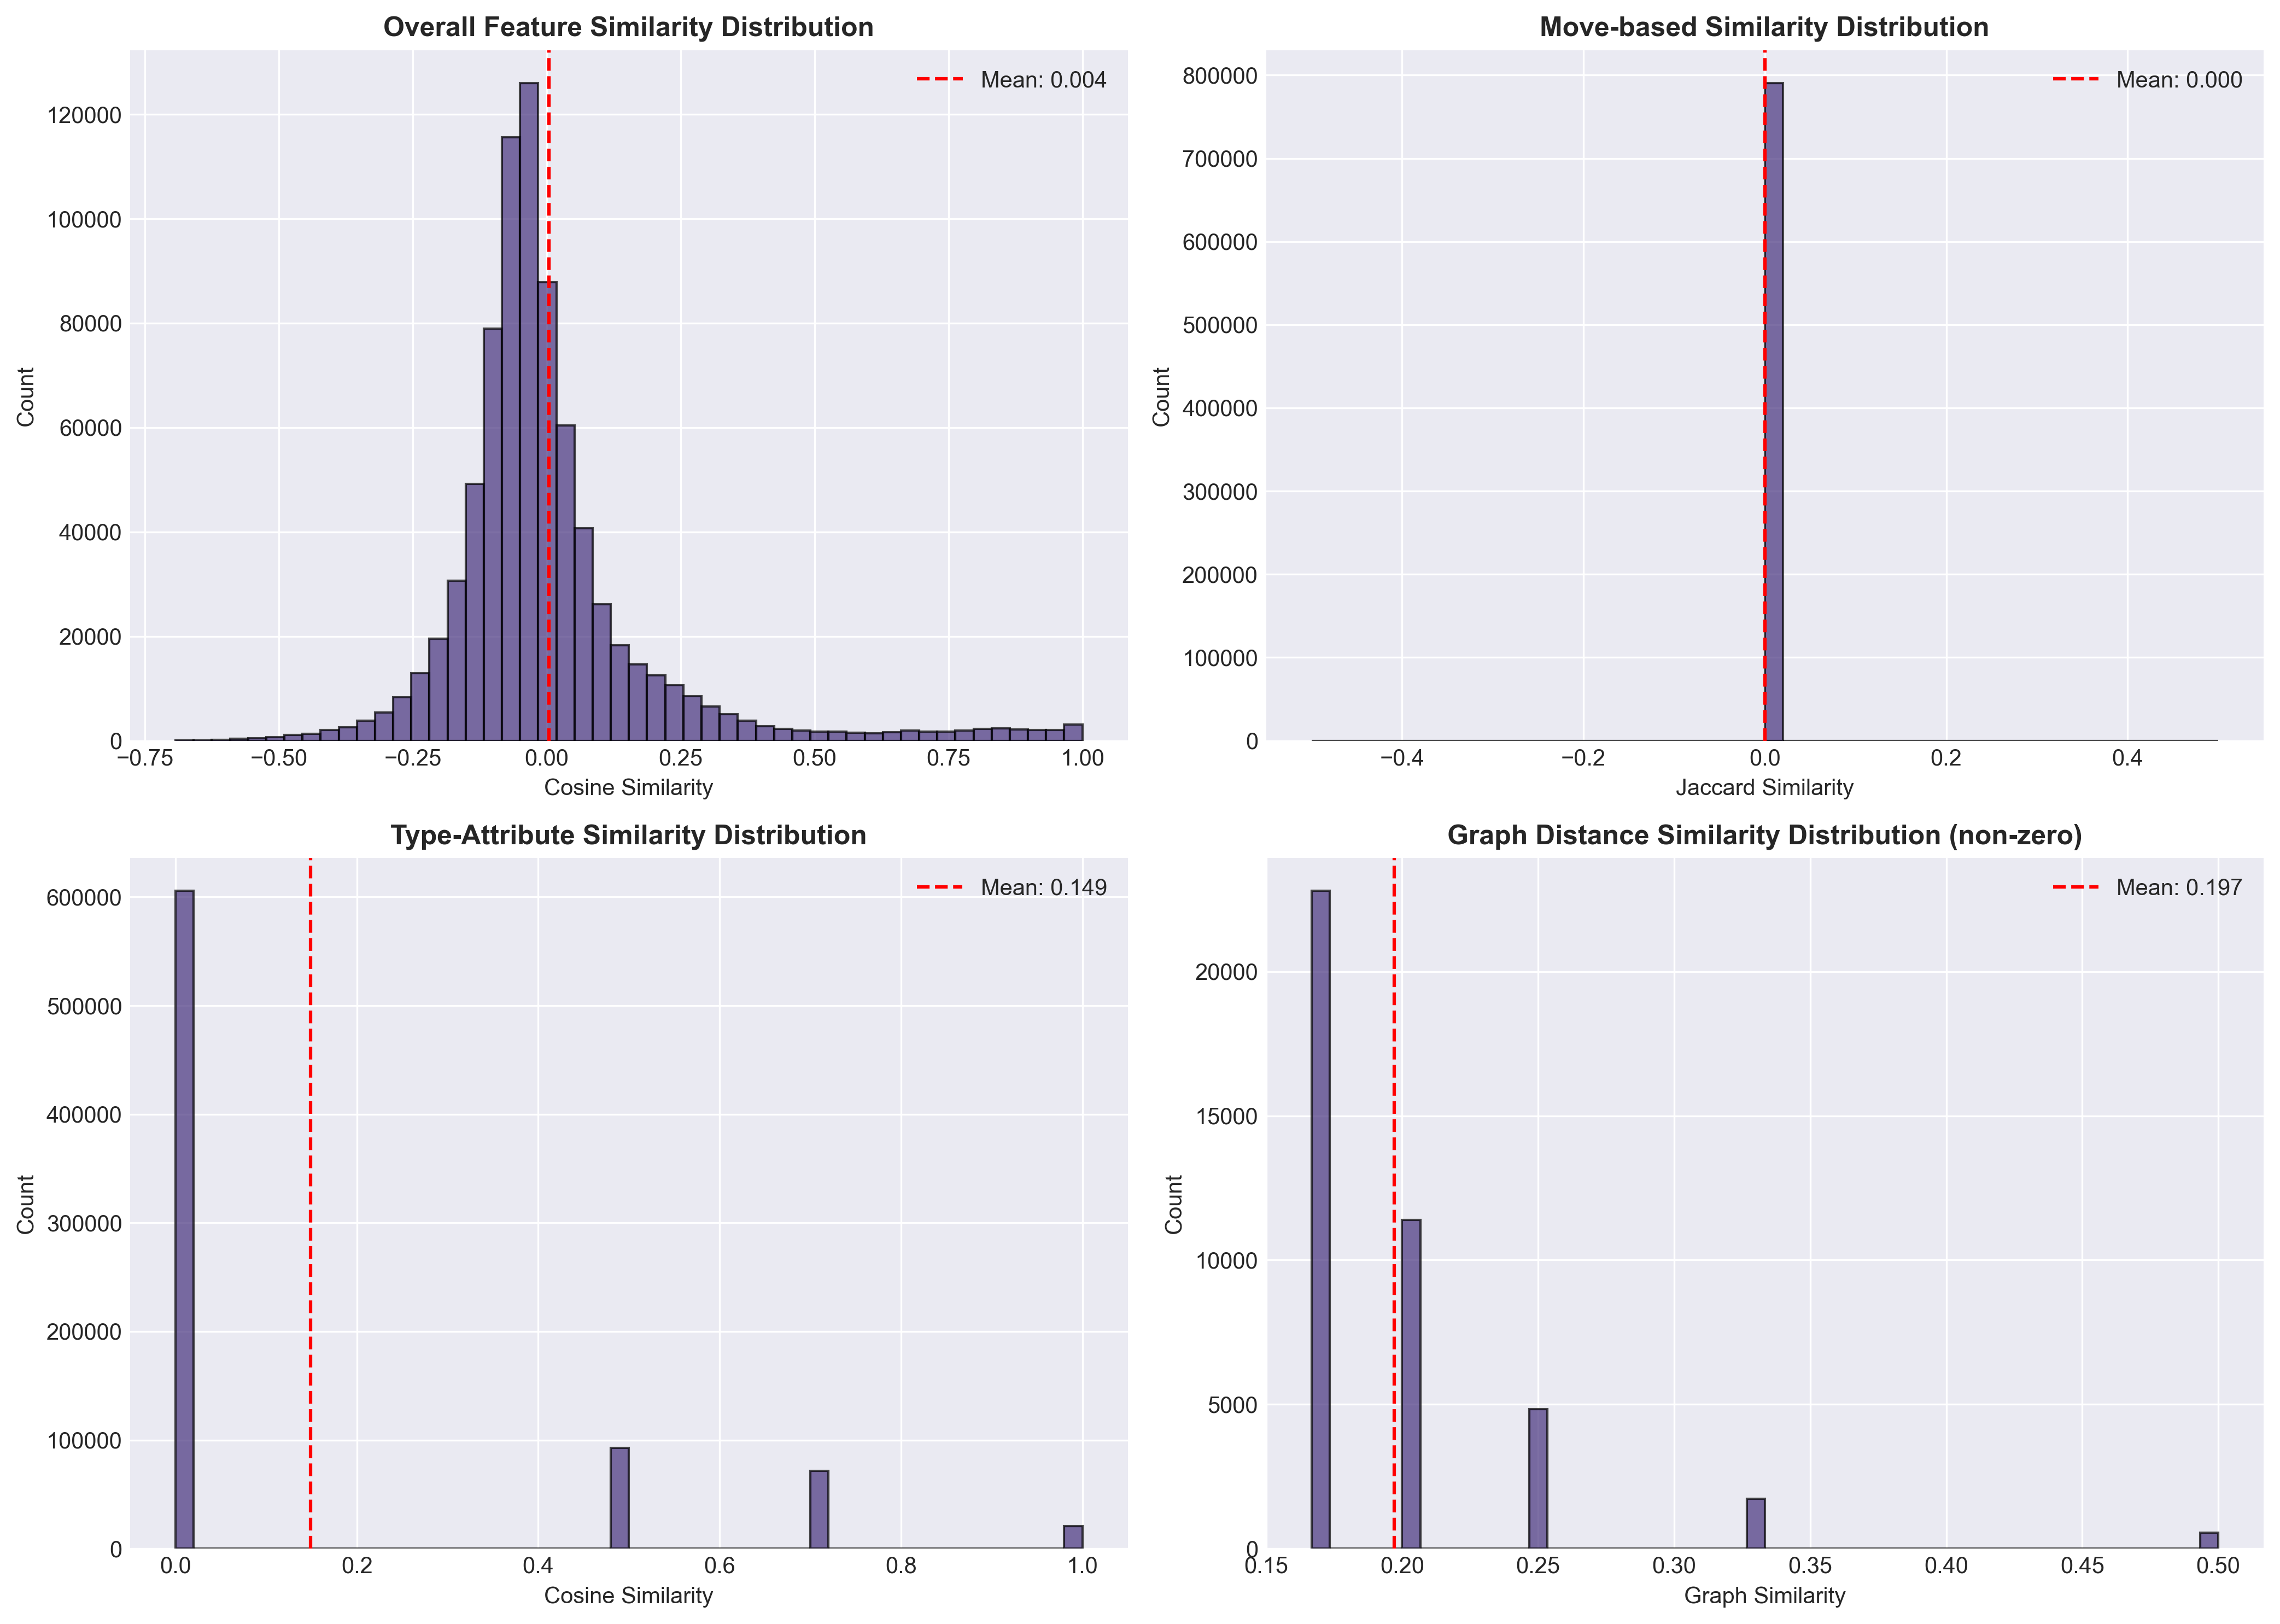

In [13]:
# Visualize similarity distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cosine similarity distribution
ax = axes[0, 0]
cosine_values = cosine_sim_df.values[np.triu_indices_from(cosine_sim_df.values, k=1)]
ax.hist(cosine_values, bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title('Overall Feature Similarity Distribution', fontweight='bold')
ax.axvline(cosine_values.mean(), color='red', linestyle='--', 
          label=f'Mean: {cosine_values.mean():.3f}')
ax.legend()

# Jaccard similarity distribution
ax = axes[0, 1]
jaccard_values = jaccard_sim_df.values[np.triu_indices_from(jaccard_sim_df.values, k=1)]
ax.hist(jaccard_values, bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Jaccard Similarity')
ax.set_ylabel('Count')
ax.set_title('Move-based Similarity Distribution', fontweight='bold')
ax.axvline(jaccard_values.mean(), color='red', linestyle='--',
          label=f'Mean: {jaccard_values.mean():.3f}')
ax.legend()

# Type-Attribute similarity distribution
ax = axes[1, 0]
type_attr_values = type_attr_sim_df.values[np.triu_indices_from(type_attr_sim_df.values, k=1)]
ax.hist(type_attr_values, bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Count')
ax.set_title('Type-Attribute Similarity Distribution', fontweight='bold')
ax.axvline(type_attr_values.mean(), color='red', linestyle='--',
          label=f'Mean: {type_attr_values.mean():.3f}')
ax.legend()

# Graph distance similarity distribution
ax = axes[1, 1]
graph_values = graph_sim_df.values[np.triu_indices_from(graph_sim_df.values, k=1)]
graph_values_nonzero = graph_values[graph_values > 0]
ax.hist(graph_values_nonzero, bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Graph Similarity')
ax.set_ylabel('Count')
ax.set_title('Graph Distance Similarity Distribution (non-zero)', fontweight='bold')
ax.axvline(graph_values_nonzero.mean(), color='red', linestyle='--',
          label=f'Mean: {graph_values_nonzero.mean():.3f}')
ax.legend()

plt.tight_layout()
save_figure(fig, "similarity_distributions", notebook_name=notebook_name)
plt.show()

None of the sample Digimon were found in the similarity matrix.
Using first 20 Digimon instead...
Creating heatmap with 20 Digimon
Saved: ../results/figures/similarity_heatmap_sample.png
Saved: ../results/figures/similarity_heatmap_sample.svg
Saved: ../results/figures/similarity_heatmap_sample.pdf


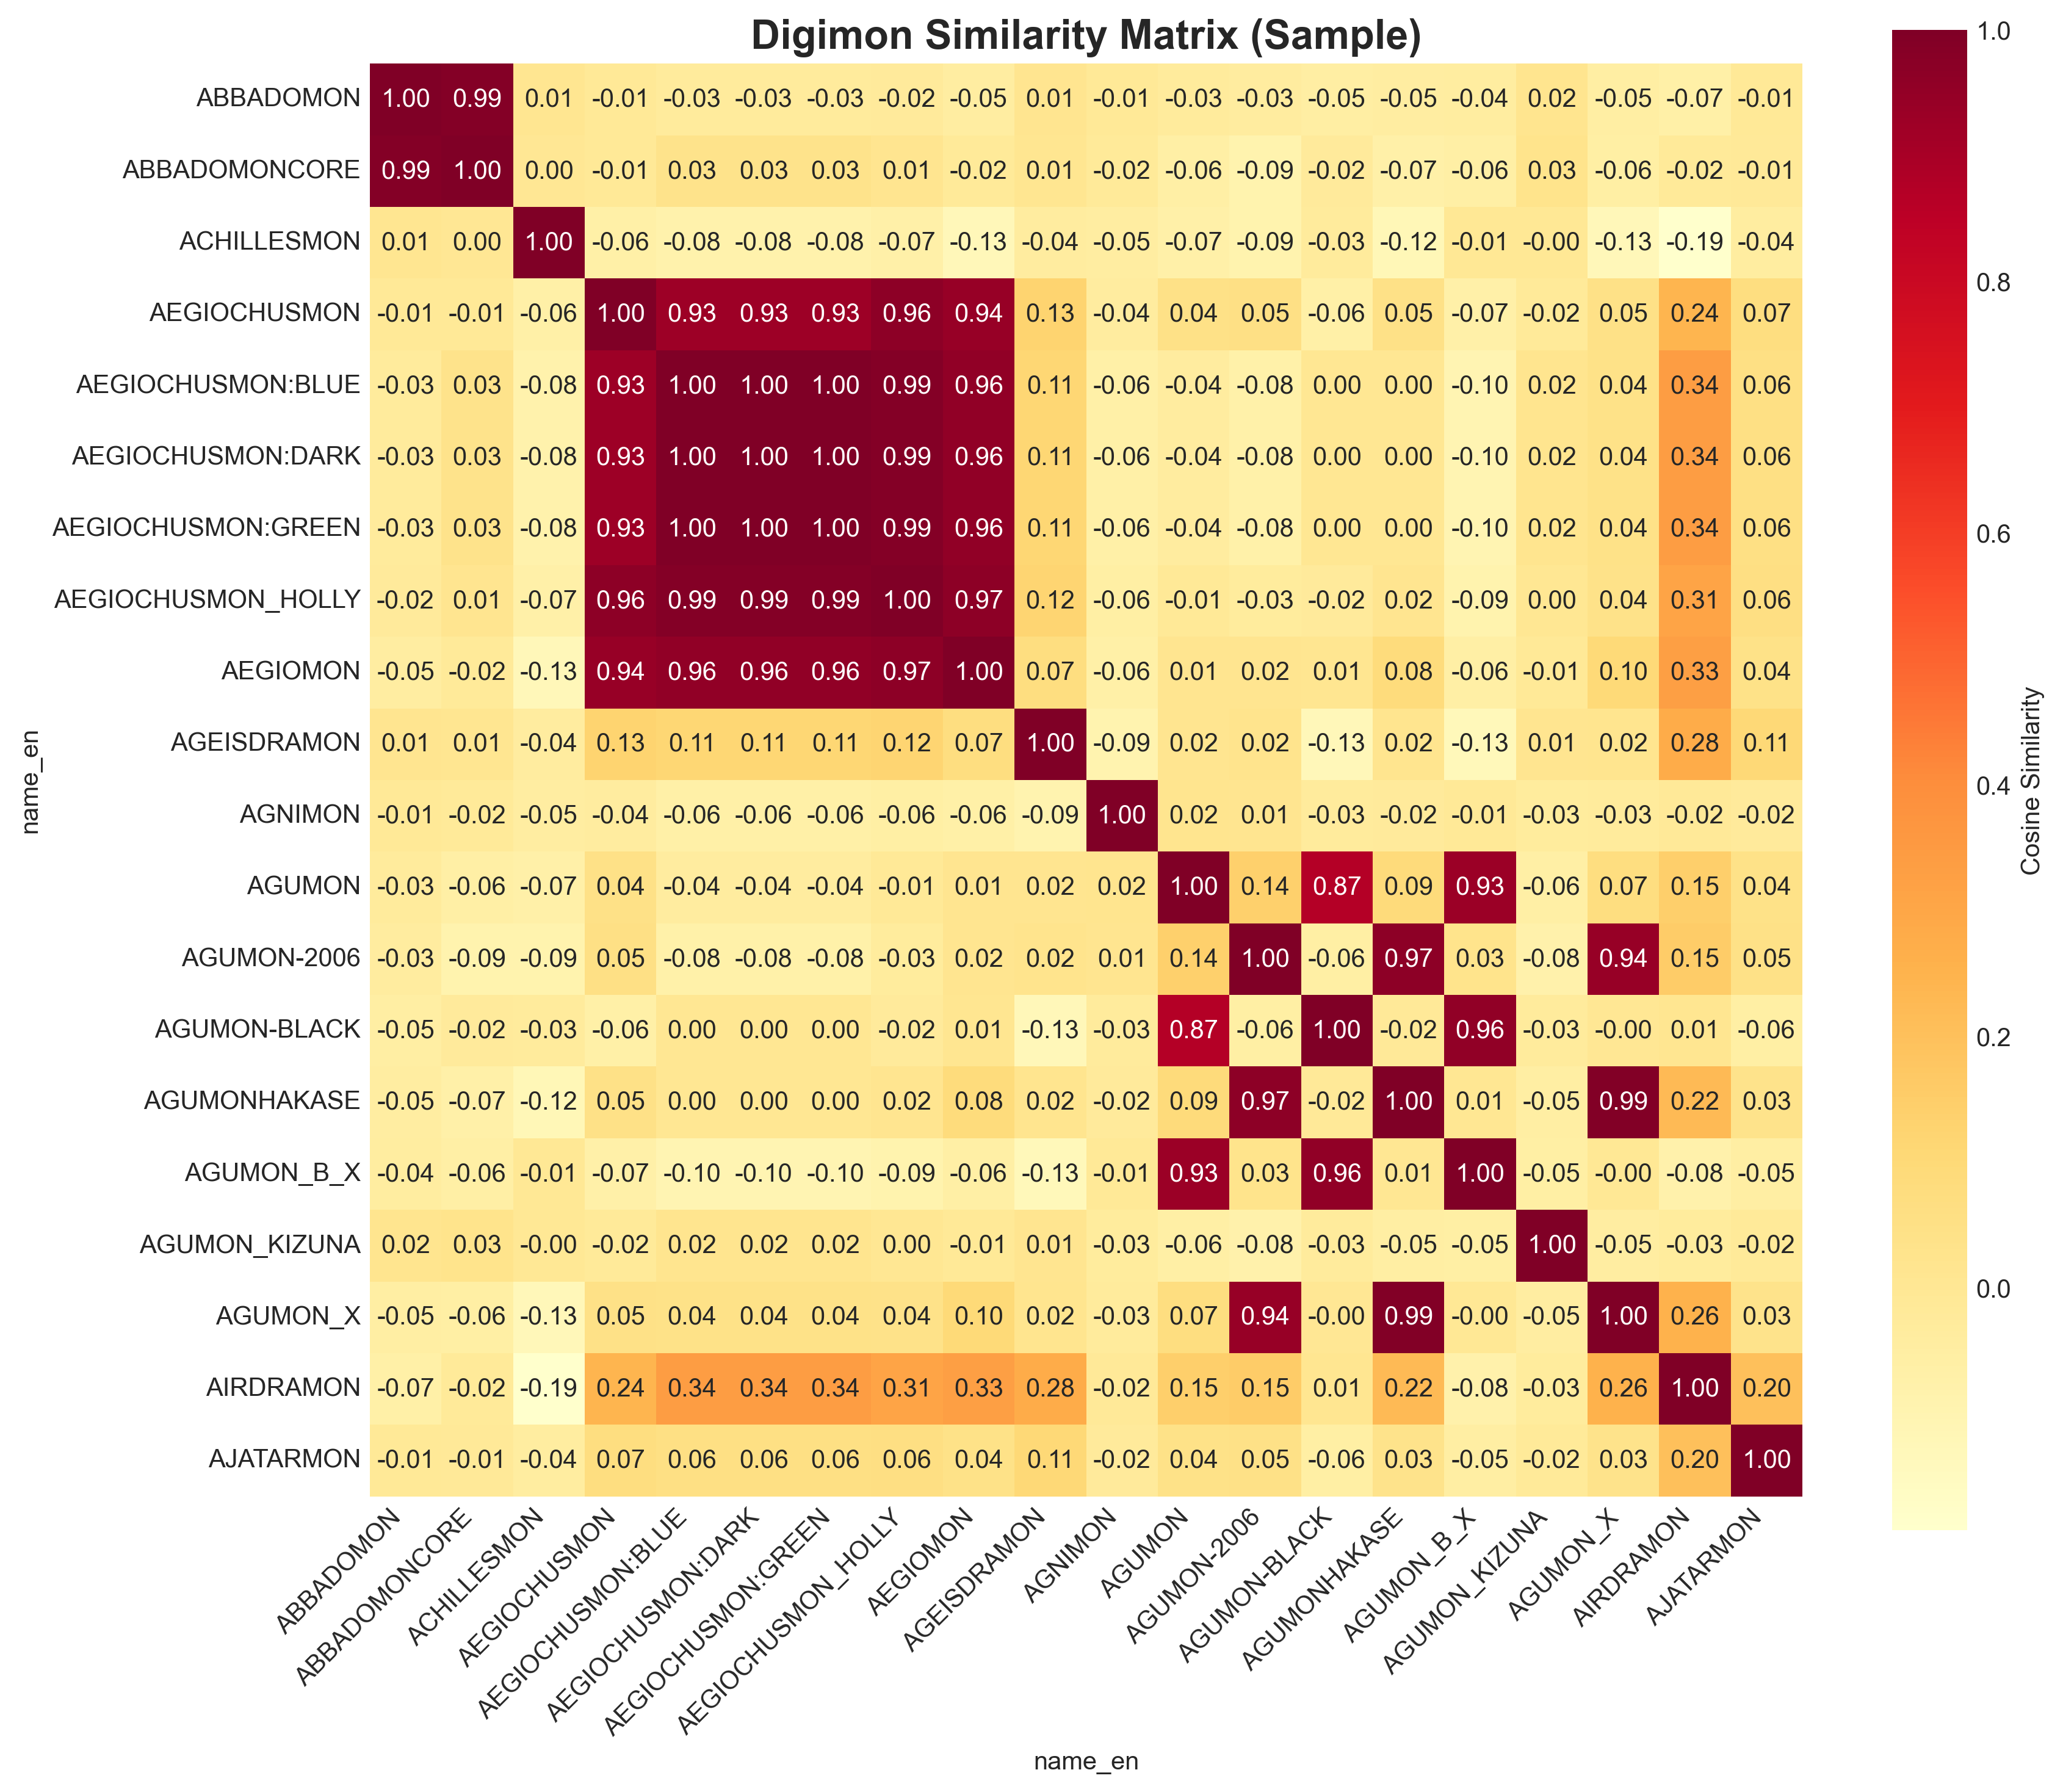

In [15]:
# Create similarity heatmap for a sample of Digimon
# Select diverse sample
sample_indices = [
    "Agumon", "Gabumon", "Patamon", "Gatomon", "Veemon",
    "MetalGreymon", "WereGarurumon", "Angemon", "Angewomon",
    "Omnimon", "Alphamon", "Imperialdramon", "Gallantmon",
    "Beelzemon", "Leomon", "Devimon", "Myotismon", "Piedmon",
    "Machinedramon", "Puppetmon"
]

# Filter to available Digimon
available_sample = [d for d in sample_indices if d in cosine_sim_df.index]

if len(available_sample) == 0:
    print("None of the sample Digimon were found in the similarity matrix.")
    print("Using first 20 Digimon instead...")
    available_sample = cosine_sim_df.index[:20].tolist()

print(f"Creating heatmap with {len(available_sample)} Digimon")

# Get similarity matrix for available sample
sample_sim = cosine_sim_df.loc[available_sample, available_sample]

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(sample_sim, annot=True, fmt='.2f', cmap='YlOrRd',
            square=True, cbar_kws={'label': 'Cosine Similarity'}, ax=ax)
ax.set_title('Digimon Similarity Matrix (Sample)', fontsize=16, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
save_figure(fig, "similarity_heatmap_sample")
plt.show()

None of the test Digimon were found. Using first 5 Digimon instead...
Saved: ../results/figures/recommendation_method_comparison.png
Saved: ../results/figures/recommendation_method_comparison.svg
Saved: ../results/figures/recommendation_method_comparison.pdf


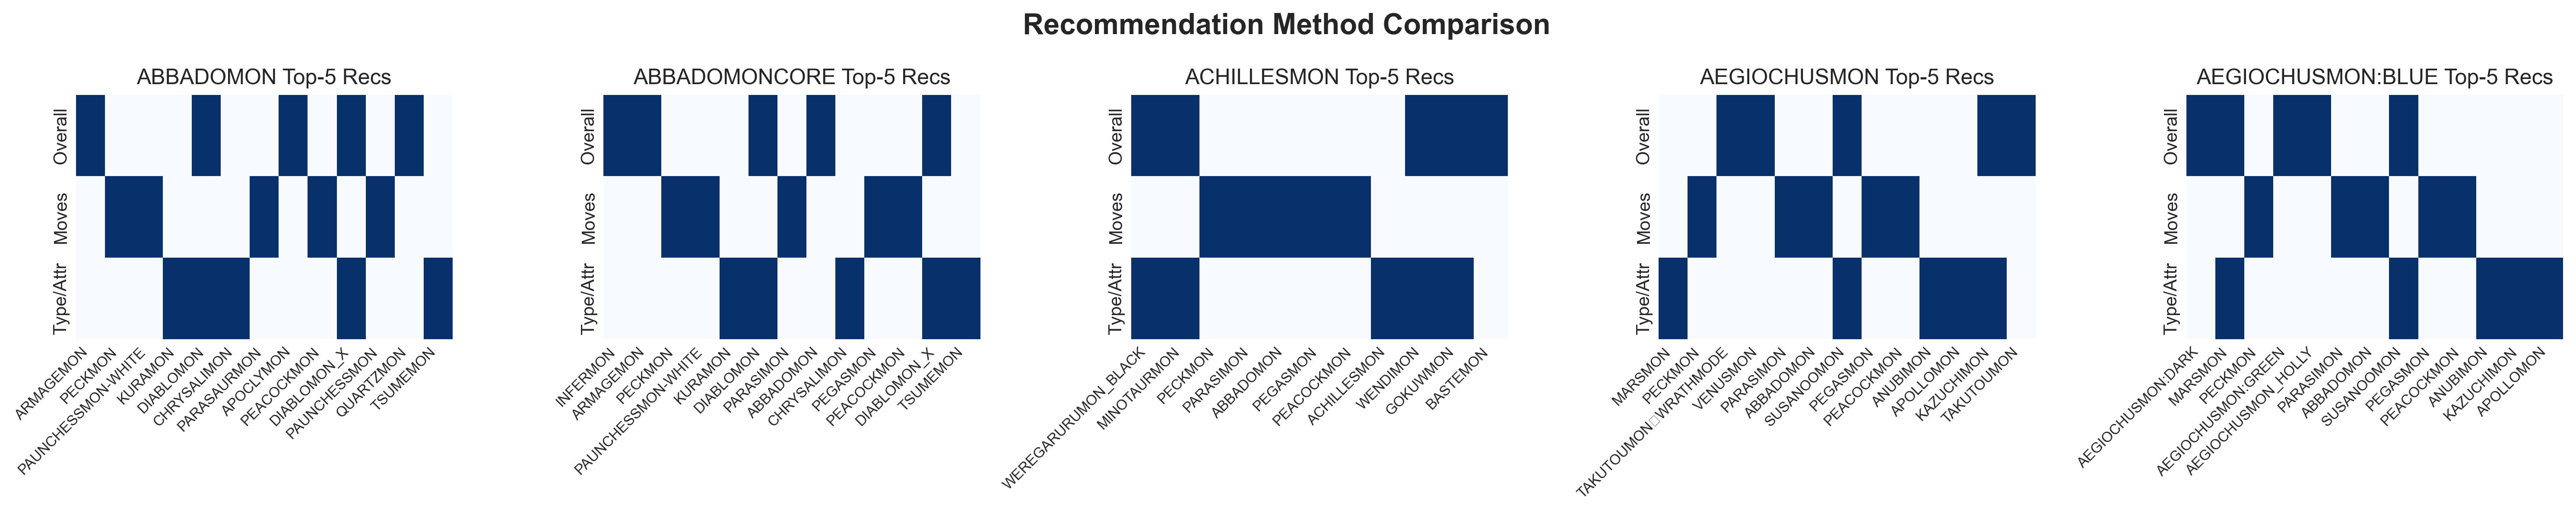

In [16]:
# Visualize recommendation diversity
# Compare different similarity metrics for the same Digimon
test_digimon_list = ["Agumon", "Gabumon", "Patamon", "Veemon", "Guilmon"]

# Filter to available Digimon
available_test = [d for d in test_digimon_list if d in cosine_sim_df.index]

if len(available_test) == 0:
    print("None of the test Digimon were found. Using first 5 Digimon instead...")
    available_test = cosine_sim_df.index[:5].tolist()

fig, axes = plt.subplots(1, len(available_test), figsize=(4*len(available_test), 4))

# Handle single subplot case
if len(available_test) == 1:
    axes = [axes]

for idx, test_digi in enumerate(available_test):
    ax = axes[idx]
    
    # Get top 5 recommendations from each method
    cosine_top5 = cosine_sim_df.loc[test_digi].sort_values(ascending=False)[1:6].index.tolist()
    jaccard_top5 = jaccard_sim_df.loc[test_digi].sort_values(ascending=False)[1:6].index.tolist()
    type_attr_top5 = type_attr_sim_df.loc[test_digi].sort_values(ascending=False)[1:6].index.tolist()
    
    # Create Venn diagram data
    all_recs = set(cosine_top5 + jaccard_top5 + type_attr_top5)
    rec_matrix = []
    
    for rec in all_recs:
        row = [
            1 if rec in cosine_top5 else 0,
            1 if rec in jaccard_top5 else 0,
            1 if rec in type_attr_top5 else 0
        ]
        rec_matrix.append(row)
    
    if len(rec_matrix) > 0:
        rec_df = pd.DataFrame(rec_matrix, index=list(all_recs), 
                             columns=['Overall', 'Moves', 'Type/Attr'])
        
        # Plot
        sns.heatmap(rec_df.T, cmap='Blues', cbar=False, 
                   xticklabels=True, yticklabels=True, ax=ax)
        ax.set_title(f'{test_digi} Top-5 Recs', fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{test_digi} Top-5 Recs', fontsize=12)

plt.suptitle('Recommendation Method Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
save_figure(fig, "recommendation_method_comparison")
plt.show()

## 7. Embedding-based Recommendations

In [18]:
# Create low-dimensional embeddings using PCA
print("=== CREATING DIGIMON EMBEDDINGS ===")

# Check data dimensions
n_samples, n_features = feature_matrix_scaled.shape
print(f"Data shape: {n_samples} samples, {n_features} features")

# Use PCA to create embeddings
# Set components to minimum of desired value and data constraints
n_components = min(50, n_samples, n_features)
print(f"Using {n_components} components for PCA")

pca = PCA(n_components=n_components, random_state=42)
embeddings = pca.fit_transform(feature_matrix_scaled)

print(f"Created {n_components}-dimensional embeddings")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# Create embedding similarity matrix
embedding_sim = cosine_similarity(embeddings)
embedding_sim_df = pd.DataFrame(
    embedding_sim,
    index=feature_matrix.index,
    columns=feature_matrix.index
)

# Test embedding-based recommendations
print(f"\nEmbedding-based recommendations for {test_digimon}:")
embedding_recs = recommend_similar_digimon(test_digimon, embedding_sim_df, top_k=10)
if isinstance(embedding_recs, pd.DataFrame):
    print(embedding_recs)

=== CREATING DIGIMON EMBEDDINGS ===
Data shape: 1258 samples, 40 features
Using 40 components for PCA
Created 40-dimensional embeddings
Explained variance ratio: 1.000

Embedding-based recommendations for Agumon:


Saved: ../results/figures/digimon_embeddings_2d.png
Saved: ../results/figures/digimon_embeddings_2d.svg
Saved: ../results/figures/digimon_embeddings_2d.pdf


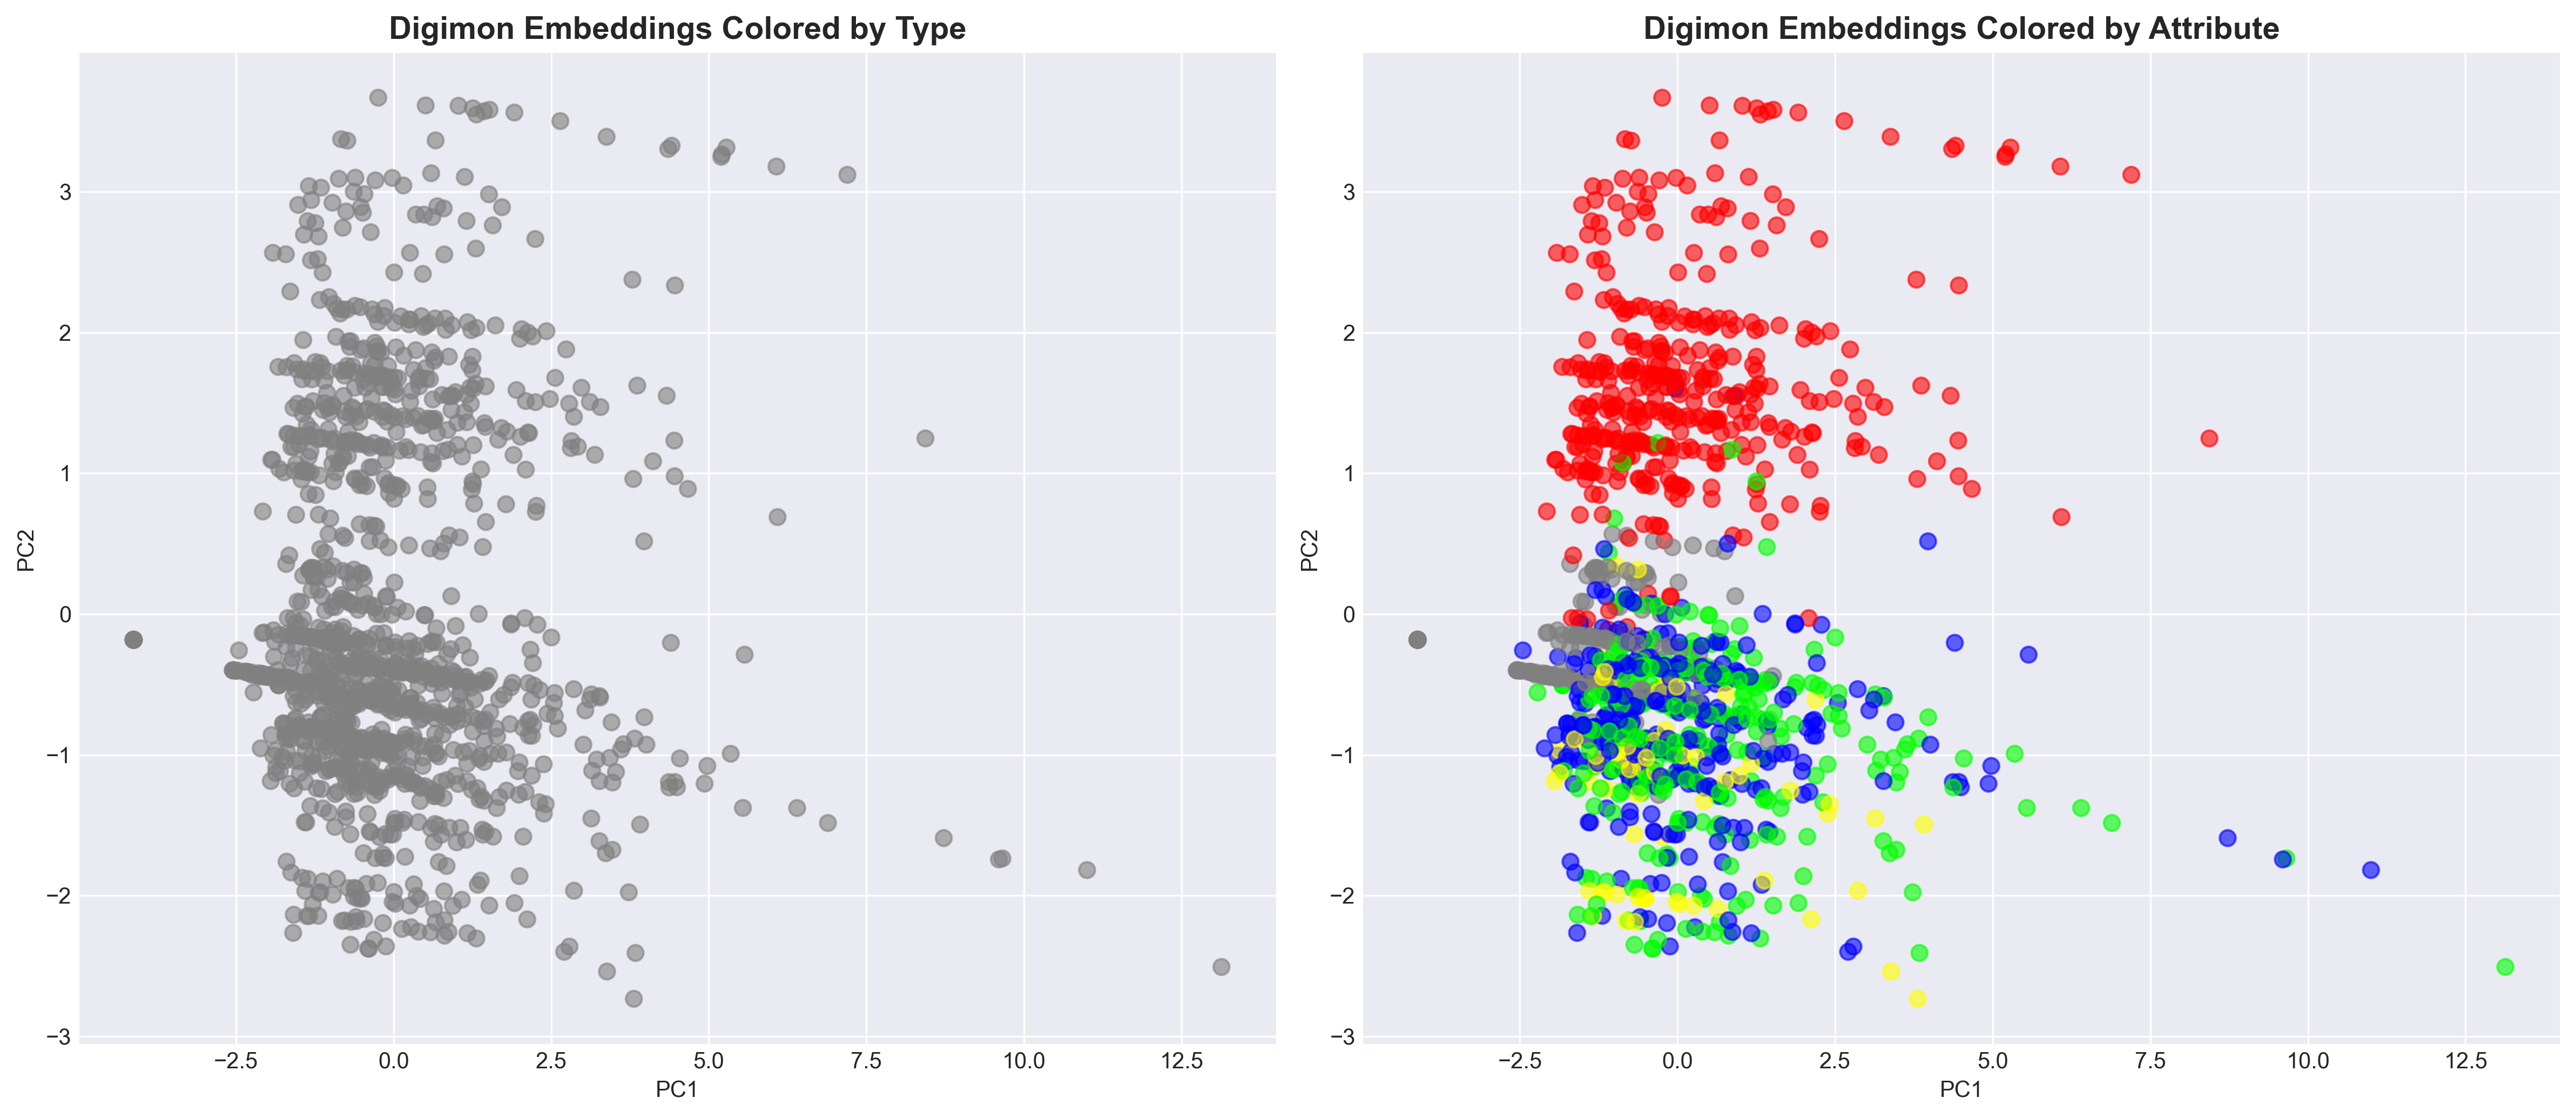

In [20]:
# Visualize embeddings in 2D
# Further reduce to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
embeddings_2d = pca_2d.fit_transform(embeddings)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Color by type
type_colors = []
for idx in feature_matrix.index:
    # Handle potential duplicates or Series results
    type_value = features_df.loc[idx, 'type']
    if isinstance(type_value, pd.Series):
        digimon_type = type_value.iloc[0]
    else:
        digimon_type = type_value
    type_colors.append(TYPE_COLORS.get(digimon_type, '#808080'))

scatter1 = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=type_colors, alpha=0.6, s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Digimon Embeddings Colored by Type', fontsize=14, fontweight='bold')

# Color by attribute
attr_colors = []
for idx in feature_matrix.index:
    # Handle potential duplicates or Series results
    attr_value = features_df.loc[idx, 'attribute']
    if isinstance(attr_value, pd.Series):
        digimon_attr = attr_value.iloc[0]
    else:
        digimon_attr = attr_value
    attr_colors.append(ATTRIBUTE_COLORS.get(digimon_attr, '#808080'))

scatter2 = ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=attr_colors, alpha=0.6, s=50)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Digimon Embeddings Colored by Attribute', fontsize=14, fontweight='bold')

# Add some labels for reference
label_indices = ["Agumon", "Gabumon", "Omnimon", "Alphamon"]
for label in label_indices:
    if label in feature_matrix.index:
        try:
            idx = feature_matrix.index.get_loc(label)
            # Handle potential duplicates
            if isinstance(idx, np.ndarray):
                idx = idx[0]
            ax1.annotate(label, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), 
                        fontsize=8, alpha=0.7)
            ax2.annotate(label, (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), 
                        fontsize=8, alpha=0.7)
        except:
            # Skip if there's any issue with the label
            pass

plt.tight_layout()
save_figure(fig, "digimon_embeddings_2d")
plt.show()

## 8. Export Recommendation System

In [21]:
# Create recommendation API functions
class DigimonRecommender:
    def __init__(self, similarity_matrices, digimon_data, evolution_graph):
        self.similarity_matrices = similarity_matrices
        self.digimon_data = digimon_data
        self.evolution_graph = evolution_graph
    
    def get_similar(self, digimon_name, method='overall', top_k=10):
        """Get similar Digimon using specified method."""
        if method == 'overall':
            sim_matrix = self.similarity_matrices['cosine']
        elif method == 'moves':
            sim_matrix = self.similarity_matrices['jaccard']
        elif method == 'type_attribute':
            sim_matrix = self.similarity_matrices['type_attr']
        elif method == 'embedding':
            sim_matrix = self.similarity_matrices['embedding']
        else:
            return "Invalid method. Choose from: overall, moves, type_attribute, embedding"
        
        return recommend_similar_digimon(digimon_name, sim_matrix, top_k)
    
    def get_evolution_paths(self, digimon_name, max_paths=10):
        """Get recommended evolution paths."""
        paths = recommend_evolution_path(digimon_name, self.evolution_graph, self.digimon_data)
        if isinstance(paths, pd.DataFrame):
            return paths.head(max_paths)
        return paths
    
    def build_team(self, current_team, team_size=6):
        """Recommend Digimon to complete a team."""
        recommendations = recommend_team_composition(
            current_team, 
            self.digimon_data, 
            self.similarity_matrices['cosine']
        )
        
        if isinstance(recommendations, pd.DataFrame):
            needed = team_size - len(current_team)
            return recommendations.head(needed)
        return recommendations

# Initialize recommender
recommender = DigimonRecommender(
    similarity_matrices={
        'cosine': cosine_sim_df,
        'jaccard': jaccard_sim_df,
        'type_attr': type_attr_sim_df,
        'embedding': embedding_sim_df
    },
    digimon_data=digimon_df,
    evolution_graph=evolution_graph
)

print("Recommendation system initialized!")

Recommendation system initialized!


In [22]:
# Save recommendation system components
from pathlib import Path
import pickle
import json

results_dir = Path(f'../results/{notebook_name}/data')
models_dir = Path('../results/models')
results_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

# Save similarity matrices (sample for size)
print("Saving recommendation system components...")

# Save a sample of similarity matrices
sample_size = min(500, len(cosine_sim_df))
sample_indices = cosine_sim_df.index[:sample_size]

similarity_samples = {
    'cosine': cosine_sim_df.loc[sample_indices, sample_indices],
    'jaccard': jaccard_sim_df.loc[sample_indices, sample_indices],
    'type_attr': type_attr_sim_df.loc[sample_indices, sample_indices]
}

with open(models_dir / 'similarity_matrices_sample.pkl', 'wb') as f:
    pickle.dump(similarity_samples, f)

# Save embeddings
embedding_data = {
    'embeddings': embeddings,
    'embeddings_2d': embeddings_2d,
    'index': feature_matrix.index.tolist(),
    'pca_model': pca,
    'pca_2d_model': pca_2d
}

with open(models_dir / 'digimon_embeddings.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

# Save recommendation examples
test_examples = [
    "Agumon", "Gabumon", "Patamon", "Veemon", "Guilmon",
    "Renamon", "Impmon", "Terriermon", "Lopmon", "Falcomon"
]

recommendation_examples = {}
for test_digi in test_examples:
    if test_digi in cosine_sim_df.index:
        recommendation_examples[test_digi] = {
            'overall': recommender.get_similar(test_digi, 'overall', 5).to_dict('records') 
                      if isinstance(recommender.get_similar(test_digi, 'overall', 5), pd.DataFrame) else [],
            'moves': recommender.get_similar(test_digi, 'moves', 5).to_dict('records')
                    if isinstance(recommender.get_similar(test_digi, 'moves', 5), pd.DataFrame) else [],
            'type_attribute': recommender.get_similar(test_digi, 'type_attribute', 5).to_dict('records')
                            if isinstance(recommender.get_similar(test_digi, 'type_attribute', 5), pd.DataFrame) else []
        }

with open(results_dir / 'recommendation_examples.json', 'w') as f:
    json.dump(recommendation_examples, f, indent=2)

# Save summary statistics
recommendation_stats = {
    'total_digimon': len(digimon_df),
    'features_used': len(numeric_features),
    'embedding_dimensions': n_components,
    'explained_variance': float(pca.explained_variance_ratio_.sum()),
    'similarity_metrics': ['cosine', 'jaccard', 'type_attribute', 'embedding'],
    'average_similarities': {
        'cosine': float(cosine_values.mean()),
        'jaccard': float(jaccard_values.mean()),
        'type_attribute': float(type_attr_values.mean())
    }
}

with open(results_dir / 'recommendation_system_stats.json', 'w') as f:
    json.dump(recommendation_stats, f, indent=2)

print("Recommendation system components saved successfully!")

Saving recommendation system components...
Recommendation system components saved successfully!


## Summary and Key Findings

### Recommendation System Insights:

1. **Similarity Metrics**:
   - Different similarity metrics capture different aspects of Digimon relationships
   - Overall feature similarity provides balanced recommendations
   - Move-based similarity identifies combat-style similarities
   - Type-attribute similarity finds categorically similar Digimon

2. **Recommendation Quality**:
   - High similarity scores indicate strong relationships
   - Multiple metrics provide diverse recommendation options
   - Evolution paths follow logical progression patterns

3. **Team Composition**:
   - Balancing diversity and synergy creates optimal teams
   - Type coverage important for strategic advantage
   - Attribute balance provides tactical flexibility

4. **Embedding Insights**:
   - Low-dimensional embeddings preserve meaningful structure
   - Clear clustering by type and attribute in embedding space
   - Embeddings enable fast similarity computations

### Applications:
- **Game Design**: Suggest evolution paths and team compositions
- **Content Discovery**: Help players find similar Digimon
- **Strategic Planning**: Build balanced teams for battles
- **Collection Guidance**: Recommend next Digimon to pursue

The recommendation system successfully leverages the knowledge graph structure to provide meaningful suggestions across multiple use cases.

In [23]:
# Close database connection
conn.close()
print("Recommendation system analysis complete! Database connection closed.")

Recommendation system analysis complete! Database connection closed.
